In [1]:
import os
import time
import requests

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering

# Map
from geopy.geocoders import GoogleV3
import folium
import googlemaps
%matplotlib inline

In [2]:
google_geo_api_key = os.environ['GOOGLE_GEO_API']
foursquare_client_id = os.environ['FOURSQUARE_CLIENT_ID']
foursquare_client_secret = os.environ['FOURSQUARE_CLIENT_SECRET']

#### Init google map client.

In [3]:
gmaps = googlemaps.Client(key=google_geo_api_key)

### 1. Prepare geo coordinate of USA cities dataset

#### Read USA city-state data.

In [5]:
usa_city_df = pd.read_csv('top_city_in_state.csv')
usa_city_df.head()

,city,state_name
0,Birmingham,Alabama
1,Mobile,Alabama
2,Huntsville,Alabama
3,Anchorage,Alaska
4,Fairbanks,Alaska


#### Add full address column.

In [51]:
usa_city_df['address'] = usa_city_df\
            .apply(lambda x: "%s, %s, USA" % (x['city'], x['state_name']), axis=1)
usa_city_df.head()

,city,state_name,address
0,Birmingham,Alabama,"Birmingham, Alabama, USA"
1,Mobile,Alabama,"Mobile, Alabama, USA"
2,Huntsville,Alabama,"Huntsville, Alabama, USA"
3,Anchorage,Alaska,"Anchorage, Alaska, USA"
4,Fairbanks,Alaska,"Fairbanks, Alaska, USA"


#### Base on full address, we use Google API to get geo coordinate of cities.

In [58]:
addresses = usa_city_df['address']
indexs = []
longitudes = []
latitudes = []
for ix, v in addresses.items():
    geolocator = GoogleV3(api_key=google_geo_api_key)
    retry = 0
    while retry < 10:
        try:
            print("Processing: " + v)
            indexs.append(ix)
            location = geolocator.geocode(v)
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
            retry = 10
        except Exception as e:
            print(e)
            time.sleep(2)
            retry = retry + 1
            print("Retry %s time for: %s" % (str(retry) , v) )
    
latitudes_series = pd.Series(data=latitudes, index=indexs)
longitudes_series = pd.Series(data=longitudes, index=indexs)
usa_city_df = usa_city_df\
                .assign(latitude=latitudes_series, longitude = longitudes_series)
usa_city_df.head()

Processing: Birmingham, Alabama, USA
Processing: Mobile, Alabama, USA
Processing: Huntsville, Alabama, USA
Processing: Anchorage, Alaska, USA
Processing: Fairbanks, Alaska, USA
Processing: Juneau, Alaska, USA
Processing: Phoenix, Arizona, USA
Processing: Tucson, Arizona, USA
Processing: Mesa, Arizona, USA
Processing: Little Rock, Arkansas, USA
Processing: Fayetteville, Arkansas, USA
Processing: Fort Smith, Arkansas, USA
Processing: Los Angeles, California, USA
Processing: San Francisco, California, USA
Processing: San Diego, California, USA
Processing: Denver, Colorado, USA
Processing: Colorado Springs, Colorado, USA
Processing: Aurora, Colorado, USA
Processing: Bridgeport, Connecticut, USA
Processing: Hartford, Connecticut, USA
Processing: New Haven, Connecticut, USA
Processing: Dover, Delaware, USA
Processing: Wilmington, Delaware, USA
Processing: Middletown, Delaware, USA
Processing: Washington, District of Columbia, USA
Processing: Miami, Florida, USA
Processing: Tampa, Florida, US

,city,state_name,address,latitude,longitude
0,Birmingham,Alabama,"Birmingham, Alabama, USA",33.518589,-86.810357
1,Mobile,Alabama,"Mobile, Alabama, USA",30.695366,-88.039891
2,Huntsville,Alabama,"Huntsville, Alabama, USA",34.730369,-86.586104
3,Anchorage,Alaska,"Anchorage, Alaska, USA",61.218056,-149.900278
4,Fairbanks,Alaska,"Fairbanks, Alaska, USA",64.837778,-147.716389


In [57]:
usa_city_df.head()

,city,state_name,address,latitude,longitude
0,Birmingham,Alabama,"Birmingham, Alabama, USA",33.518589,-86.810357
1,Mobile,Alabama,"Mobile, Alabama, USA",30.695366,-88.039891
2,Huntsville,Alabama,"Huntsville, Alabama, USA",34.730369,-86.586104
3,Anchorage,Alaska,"Anchorage, Alaska, USA",61.218056,-149.900278
4,Fairbanks,Alaska,"Fairbanks, Alaska, USA",64.837778,-147.716389


### 2. Prepare venue categories of each city dataset

In [66]:
def get_category_types(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories'] 
    if len(categories_list) == 0:
        return None
    else:
        return [x['name'] for x in categories_list]
    
# https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows
def explode_col(df, explode_col, value_col):
    indexes = list()
    new_values = list()
    for i, value_list in enumerate(df[explode_col]):
        for value in value_list:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[value_col] = new_values
    new_df.reset_index(drop=True, inplace=True)
    new_df.drop(explode_col, axis=1, inplace=True)
    return new_df

#### Now using Foursquare API to get top 100 venues of each city, then transform to category-cityname pairs Dataframe

In [75]:
LIMIT = 100
radius = 50000
VERSION = '20190418'

explore_url_template = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}"
usa_cities = usa_city_df.to_dict('records')
dfs = []
error_city = []
for city in usa_cities:
    retry = 0
    while retry < 10:
        try:
            city_name = city['city']
            city_lat = city['latitude']
            city_long = city['longitude']
            explore_url = explore_url_template.format(
                foursquare_client_id, 
                foursquare_client_secret, 
                VERSION, 
                city_lat, 
                city_long, 
                radius, 
                LIMIT)    
            print("Processing city: " + city_name)

            # Request API
            results = requests.get(explore_url).json()

            venues = results['response']['groups'][0]['items']
            nearby_venues = json_normalize(venues)
            selected_columns = ['venue.name', 'venue.categories']
            nearby_venues = nearby_venues[selected_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_types, axis=1)
            nearby_venue_cates = explode_col(nearby_venues[['venue.categories']],\
                                         'venue.categories', 'categories')
            nearby_venue_cates = nearby_venue_cates.assign(city = city_name)
            dfs.append(nearby_venue_cates)
            retry = 10
        except Exception as e:
            error_city.append(city)
            print(e)
            time.sleep(2)
            retry = retry + 1
            print("Retry %s time for: %s" % (str(retry) , city_name))
    
usa_city_venues = pd.concat(dfs)
usa_city_venues.head(10)

Processing city: Birmingham
Processing city: Mobile
Processing city: Huntsville
Processing city: Anchorage
Processing city: Fairbanks
Processing city: Juneau
Processing city: Phoenix
Processing city: Tucson
Processing city: Mesa
Processing city: Little Rock
Processing city: Fayetteville
Processing city: Fort Smith
Processing city: Los Angeles
Processing city: San Francisco
Processing city: San Diego
Processing city: Denver
Processing city: Colorado Springs
Processing city: Aurora
Processing city: Bridgeport
Processing city: Hartford
Processing city: New Haven
Processing city: Dover
Processing city: Wilmington
Processing city: Middletown
Processing city: Washington
Processing city: Miami
Processing city: Tampa
Processing city: Orlando
Processing city: Atlanta
Processing city: Augusta
Processing city: Savannah
Processing city: Honolulu
Processing city: Waipiʻo Acres
Processing city: ʻEwa Gentry
Processing city: Boise
Processing city: Nampa
Processing city: Coeur d'Alene
Processing city: 

,categories,city
0,Mexican Restaurant,Birmingham
1,Science Museum,Birmingham
2,Park,Birmingham
3,Art Museum,Birmingham
4,Brewery,Birmingham
5,Asian Restaurant,Birmingham
6,Theater,Birmingham
7,Bar,Birmingham
8,Music Venue,Birmingham
9,History Museum,Birmingham


In [58]:
usa_city_venues.head()

,categories,city
0,Mexican Restaurant,Birmingham
1,Science Museum,Birmingham
2,Park,Birmingham
3,Art Museum,Birmingham
4,Brewery,Birmingham


In [2]:
# usa_city_venues = pd.read_csv('usa_city_venues.csv')

#### Explore data

In [11]:
cates = usa_city_venues['categories']

In [12]:
cates.nunique()

420

In [13]:
count_series = cates.value_counts()

In [14]:
# Top 10 popular venues
count_series[:10]

Coffee Shop            677
American Restaurant    655
Pizza Place            601
Park                   509
Brewery                498
Mexican Restaurant     420
Bar                    358
Grocery Store          355
Italian Restaurant     332
Ice Cream Shop         317
Name: categories, dtype: int64

### 3. Prepare input data for clustering model

#### Create one hot encoding vector for each city from venues categories

In [6]:
onehot_category_df = pd.get_dummies(usa_city_venues['categories'], prefix='cate')
onehot_category_df = onehot_category_df.assign(city = usa_city_venues['city'])
onehot_category_df.head()

,cate_ATM,cate_Accessories Store,cate_Adult Boutique,cate_Afghan Restaurant,cate_African Restaurant,cate_Airport,cate_Airport Service,cate_American Restaurant,cate_Amphitheater,cate_Animal Shelter,...,cate_Whisky Bar,cate_Wine Bar,cate_Wine Shop,cate_Winery,cate_Wings Joint,cate_Women's Store,cate_Yoga Studio,cate_Zoo,cate_Zoo Exhibit,city
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Birmingham
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Birmingham
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Birmingham
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Birmingham
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Birmingham


In [7]:
avg_df = onehot_category_df.groupby(['city'], as_index=False).mean()
avg_df.head()

,city,cate_ATM,cate_Accessories Store,cate_Adult Boutique,cate_Afghan Restaurant,cate_African Restaurant,cate_Airport,cate_Airport Service,cate_American Restaurant,cate_Amphitheater,...,cate_Waterfront,cate_Whisky Bar,cate_Wine Bar,cate_Wine Shop,cate_Winery,cate_Wings Joint,cate_Women's Store,cate_Yoga Studio,cate_Zoo,cate_Zoo Exhibit
0,Aberdeen,0.020408,0.0,0.0,0.0,0.0,0.00,0.0,0.122449,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
1,Albuquerque,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.040000,0.0,...,0.0,0.00,0.01,0.01,0.00,0.00,0.0,0.00,0.01,0.0
2,Allentown,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.060000,0.0,...,0.0,0.00,0.00,0.00,0.01,0.00,0.0,0.01,0.00,0.0
3,Anchorage,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.030000,0.0,...,0.0,0.00,0.00,0.00,0.00,0.01,0.0,0.01,0.00,0.0
4,Appleton,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.030000,0.0,...,0.0,0.01,0.01,0.00,0.00,0.01,0.0,0.00,0.00,0.0


#### Change to numpy matrix for calculating

In [45]:
cate_frequency_matrix = avg_df.iloc[:, 1:].values
cate_frequency_matrix

array([[ 0.02040816,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01      ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.01      ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01      ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

#### Calculate cosine similarity matrix for one-hot vectors in previous step

#### Please refer to my report and presentation to see why we choose cosine similarity

In [46]:
cs_matrix = cosine_similarity(cate_frequency_matrix)
cs_matrix

array([[ 1.        ,  0.45243965,  0.54218539, ...,  0.74029754,
         0.5485567 ,  0.19501802],
       [ 0.45243965,  1.        ,  0.5314489 , ...,  0.57086298,
         0.60417542,  0.27679617],
       [ 0.54218539,  0.5314489 ,  1.        , ...,  0.6118078 ,
         0.71153229,  0.28766564],
       ..., 
       [ 0.74029754,  0.57086298,  0.6118078 , ...,  1.        ,
         0.67409224,  0.33110556],
       [ 0.5485567 ,  0.60417542,  0.71153229, ...,  0.67409224,
         1.        ,  0.2393775 ],
       [ 0.19501802,  0.27679617,  0.28766564, ...,  0.33110556,
         0.2393775 ,  1.        ]])

### 4. Clustering cities

#### Using Spectral Clustering - please refer to the report and presentation for details

In [47]:
kclusters = 6
clustering = SpectralClustering(n_clusters=kclusters, random_state=0, \
                                affinity='precomputed')\
            .fit(cs_matrix)

In [48]:
cluster_labels = clustering.labels_

#### Add cluster labels for cities

In [49]:
label_group_df = avg_df['city'].to_frame()
label_group_df.head()

,city
0,Aberdeen
1,Albuquerque
2,Allentown
3,Anchorage
4,Appleton


In [50]:
label_group_df.insert(0, 'label', cluster_labels)

In [51]:
label_group_df.head(10)

,label,city
0,3,Aberdeen
1,4,Albuquerque
2,0,Allentown
3,4,Anchorage
4,4,Appleton
5,0,Atlanta
6,3,Augusta
7,0,Aurora
8,1,Baltimore
9,3,Bangor


In [52]:
usa_city_df.head()

,city,state_name,address,latitude,longitude
0,Birmingham,Alabama,"Birmingham, Alabama, USA",33.518589,-86.810357
1,Mobile,Alabama,"Mobile, Alabama, USA",30.695366,-88.039891
2,Huntsville,Alabama,"Huntsville, Alabama, USA",34.730369,-86.586104
3,Anchorage,Alaska,"Anchorage, Alaska, USA",61.218056,-149.900278
4,Fairbanks,Alaska,"Fairbanks, Alaska, USA",64.837778,-147.716389


#### Join geo data and labeled data, we use result dataframe to show on map

In [53]:
usa_city_labeled = label_group_df.merge(usa_city_df, on=['city'], how='inner')
usa_city_labeled = usa_city_labeled[['label', 'city', 'latitude', 'longitude']]
usa_city_labeled.head()

,label,city,latitude,longitude
0,3,Aberdeen,45.464698,-98.486483
1,4,Albuquerque,35.084386,-106.650422
2,0,Allentown,40.602294,-75.471410
3,4,Anchorage,61.218056,-149.900278
4,4,Appleton,44.261931,-88.415385


#### Show clustering result on USA map

In [54]:
# create map
usa_lat = 39.381266
usa_long = -97.922211
map_clusters = folium.Map(location=[usa_lat, usa_long], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, cluster in zip(usa_city_labeled['latitude'], usa_city_labeled['longitude'], usa_city_labeled['city'], usa_city_labeled['label']):
    label = folium.Popup("%s (%s)" % (city, str(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

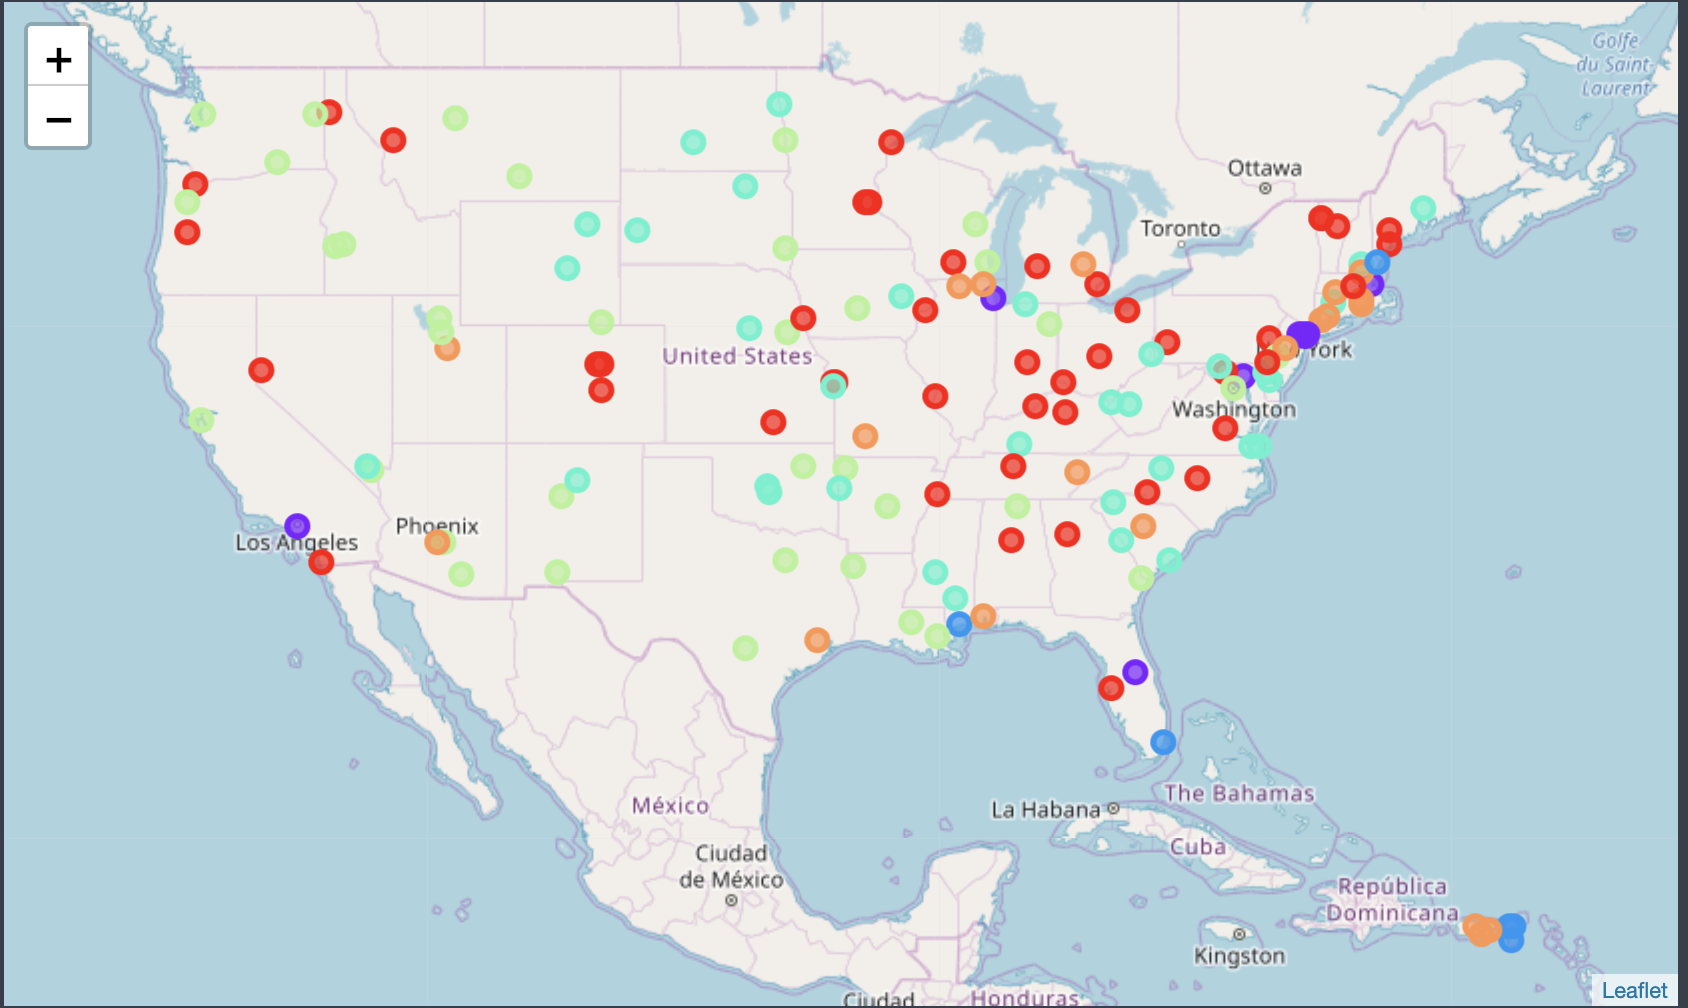

In [68]:
# In case GitHub not render map
# from IPython.core.display import Image, display
# display(Image('map.png', unconfined=False))